In [1]:
import os
from mxnet import gluon
import zipfile
import tarfile

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
# Saved in the d2l package for later use
def download(name, cache_dir='../data'):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, "%s doesn't exist" % name
    url, sha1 = DATA_HUB[name]
    d2l.mkdir_if_not_exist(cache_dir)
    return gluon.utils.download(url, cache_dir, sha1_hash=sha1)

In [3]:
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext == '.tar' or ext == '.gz':
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted'
    fp.extractall(base_dir)
    if folder:
        return base_dir + '/' + folder + '/'
    else:
        return data_dir + '/'

# Saved in the d2l package for later use
def download_all():
    """Download all files in the DATA_HUB"""
    for name in DATA_HUB:
        download(name)

In [4]:
%matplotlib inline
import d2l
from mxnet import autograd, init, np, npx
from mxnet.gluon import nn
import pandas as pd
npx.set_np()

In [5]:
# Saved in the d2l package for later use
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

# Saved in the d2l package for later use
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [9]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [40]:
# droped id column
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [41]:
def standardize_and_fill(df):
    numeric_features = df.dtypes[df.dtypes != 'object'].index
    df[numeric_features] = (df[numeric_features]
                            .apply(lambda x: (x-x.mean())/ x.std()))
    df[numeric_features] = df[numeric_features].fillna(0)
    return df

In [42]:
all_features = all_features.pipe(standardize_and_fill)

In [43]:
all_features.describe().round()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.0,2919.0,2919.0,2919.0,2919.0,2919.0,2919.0,2919.0,2919.0,2919.0,...,2919.0,2919.0,2919.0,2919.0,2919.0,2919.0,2919.0,2919.0,2919.0,2919.0
mean,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.0,-2.0,-1.0,-4.0,-4.0,-3.0,-2.0,-1.0,-1.0,-0.0,...,-2.0,-1.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-2.0,-1.0
25%,-1.0,-0.0,-0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.0,...,-1.0,-1.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,-1.0
50%,-0.0,0.0,-0.0,-0.0,-1.0,0.0,0.0,-1.0,-0.0,-0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
75%,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-0.0,...,0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,1.0
max,3.0,10.0,26.0,3.0,3.0,1.0,1.0,8.0,11.0,9.0,...,5.0,11.0,10.0,15.0,20.0,10.0,22.0,30.0,2.0,2.0


In [44]:
all_features.shape

(2919, 79)

In [45]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and
# creates an indicative feature for it
# one hot encoding for discrete values
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [48]:
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values, dtype=np.float32)
test_features = np.array(all_features[n_train:].values, dtype=np.float32)
train_labels = np.array(train_data.SalePrice.values,
                        dtype=np.float32).reshape(-1, 1)

In [54]:
loss = gluon.loss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [55]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = np.clip(net(features), 1, float('inf'))
    return np.sqrt(2 * loss(np.log(clipped_preds), np.log(labels)).mean())

In [56]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [57]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate((X_train, X_part), axis=0)
            y_train = np.concatenate((y_train, y_part), axis=0)
    return X_train, y_train, X_valid, y_valid

In [58]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse: 0.169999, valid rmse: 0.157142
fold 1, train rmse: 0.161970, valid rmse: 0.189024
fold 2, train rmse: 0.163566, valid rmse: 0.167926
fold 3, train rmse: 0.167762, valid rmse: 0.154796
fold 4, train rmse: 0.162665, valid rmse: 0.182747
5-fold validation: avg train rmse: 0.165193, avg valid rmse: 0.170327


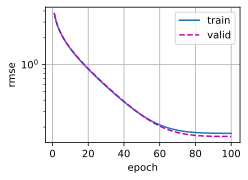

In [59]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

In [60]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='rmse', yscale='log')
    print('train rmse %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_features).asnumpy()
    # Reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train rmse 0.162590


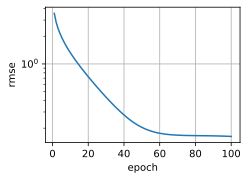

In [61]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)